In [0]:
import torch 
from torch.nn import Conv2d, MaxPool2d, ReLU, Softmax
from torch import optim
import torch.nn as nn
import torchvision 
import torchvision.datasets as dsets
import torchvision.models as models
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(777)
if device == 'cuda':
  torch.cuda.manual_seed_all(777)

In [0]:
lr = 0.001
training_epochs = 40
batch_size = 30

In [0]:
transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])

In [249]:
# dataset 

cifar_train = dsets.CIFAR10(root='./cifar10', train=True, transform=transform, download=True)
cifar_test = dsets.CIFAR10(root='./cifar10', train=False, transform=transform, download=True)

Files already downloaded and verified
Files already downloaded and verified


In [0]:
trainld = torch.utils.data.DataLoader(cifar_train, batch_size=batch_size, shuffle=True, num_workers=2)
testld = torch.utils.data.DataLoader(cifar_test, batch_size=batch_size, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

torch.Size([30, 3, 32, 32])


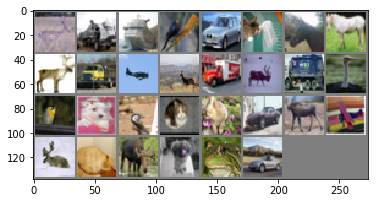

In [264]:
import matplotlib.pyplot as plt
import numpy as np

# 이미지를 보여주기 위한 함수


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# 학습용 이미지를 무작위로 가져오기
dataiter = iter(trainld)
images, labels = dataiter.next()

print(images.size())

# 이미지 보여주기
imshow(torchvision.utils.make_grid(images))


In [0]:
class AlexNet_mod(nn.Module):
  def __init__(self, n_classes, init_weights=True):
    super(AlexNet_mod, self).__init__()
    #inpu 32,32,3
    self.features = nn.Sequential(
        #conv1 layer 32, 32, 3 => 27, 27, 96
        Conv2d(3, 96, kernel_size=6, stride=1, padding=0),
        ReLU(),
        #conv2 layer 27, 27, 96 => 27, 27, 256
        Conv2d(96, 256, kernel_size=3, stride=1, padding=1),
        # 13, 13, 256
        MaxPool2d(kernel_size=3, stride=2),
        ReLU(),
        #conv3 layer 13, 13, 256 => 13, 13, 384
        Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
        Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
        Conv2d(384, 256, kernel_size=3, stride=1, padding=1))
    
    self.avgpool = nn.AdaptiveAvgPool2d((6,6))
    
    self.classifier = nn.Sequential(
        nn.Linear(6*6*256, 4096, bias=True),
        ReLU(),
        nn.Dropout(),
        nn.Linear(4096, 4096, bias=True),
        ReLU(),
        nn.Dropout(),
        nn.Linear(4096, n_classes, bias=True))
  
  def forward(self, x):
    x = self.features(x)
    x = self.avgpool(x)
    x = x.view(x.size(0), -1)
    x = self.classifier(x)
    return(x)
  
  def _initialize_weights(self):
    for m in self.modules():
      if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
          nn.init.constant_(m.bias, 0)
      elif isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)
      elif isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, 0, 0.01)
        nn.init.constant_(m.bias, 0)

In [269]:
model2 = AlexNet_mod(n_classes=10).to(device)
model2

AlexNet_mod(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(6, 6), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(96, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): ReLU()
    (5): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Linear(in_features=9216, out_features=4096, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5)
    (3): Linear(in_features=4096, out_features=4096, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5)
    (6): Linear(in_features=4096, out_features=10, bias=True)
  )
)

In [270]:
a = torch.Tensor(1, 3, 32, 32).to(device)
out = model2(a)
print(out)

tensor([[  2011828.5000,  -1871733.1250,    396086.8750,   1042100.6875,
           -497302.4375, -11021215.0000,  -3183013.0000,    -40844.0469,
           2071280.0000,  -1260040.3750]], device='cuda:0',
       grad_fn=<AddmmBackward>)


In [0]:
hist1_steps = []
hist1_losses = []

In [0]:
total_batch = len(trainld)

In [0]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model2.parameters(), lr=lr)

In [0]:
print('Learning started')
for epoch in range(training_epochs):
  avg_cost = 0
  
  for inputs, labels in trainld:
    inputs = inputs.to(device)
    labels = labels.to(device)
    
    optimizer.zero_grad()
    hypothesis = model2(inputs).to(device)
    cost = criterion(hypothesis, labels)
    cost.backward()
    optimizer.step()
    
    avg_cost += cost/total_batch
    
  hist1_steps.append(epoch+1)
  hist1_losses.append(avg_cost)
  
  print('[Epoch {}] Cost = {:.9f}'.format(epoch+1, avg_cost))
  
print('Learning Completed')

Learning started
[Epoch 1] Cost = 2.302983046
[Epoch 2] Cost = 2.302783012


In [0]:
# 시험삼아 결과 보기 
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [0]:
outputs = model2(images)

In [0]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

In [0]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model2(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

In [0]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model2(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))